In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import sklearn
import pandas as pd
pd.set_option('display.max_columns', None)
import os

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def set_aspect(ax,log_x,log_y):
    if(log_x and log_y):
        ax.set_aspect(np.log10(ax.get_xlim()[1]/ax.get_xlim()[0])/np.log10(ax.get_ylim()[1]/ax.get_ylim()[0]))
    elif(log_x):
        ax.set_aspect(np.log10(ax.get_xlim()[1]/ax.get_xlim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]))
    elif(log_y):
        ax.set_aspect((ax.get_xlim()[1]-ax.get_xlim()[0])/np.log10(ax.get_ylim()[1]/ax.get_ylim()[0]))
    else:
        ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))

# Getting the Data

## Download Mushroom Data

In [2]:
from zipfile import ZipFile
import urllib.request

DOWNLOAD_ROOT = "https://archive.ics.uci.edu/static/public/73/"
MUSHROOM_PATH = os.path.join("datasets", "mushrooms")
MUSHROOM_URL = DOWNLOAD_ROOT + "mushroom.zip"

def fetch_mushroom_data(mushroom_url=MUSHROOM_URL, mushroom_path=MUSHROOM_PATH):
    if not os.path.isdir(mushroom_path):
        os.makedirs(mushroom_path)
    zip_path = os.path.join(mushroom_path, "mushroom.zip")
    urllib.request.urlretrieve(mushroom_url, zip_path)

    with ZipFile(zip_path) as mushrooms_zip:
        mushrooms_zip.extractall(path=mushroom_path)

In [3]:
fetch_mushroom_data()

In [4]:
def load_mushroom_data(mushroom_path=MUSHROOM_PATH):
    data_path = os.path.join(mushroom_path, "agaricus-lepiota.data")
    name_path = os.path.join(mushroom_path, "agaricus-lepiota.names")
    column_names = ['class','cap-shape','cap-surface','cap-color','bruises?','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring',
                    'stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']
    return pd.read_csv(data_path,names=column_names)

## Taking a Quick Look at the Data Structure

From agarius-lepiota.names:

In [5]:
with open(os.path.join(MUSHROOM_PATH, "agaricus-lepiota.names"), 'r') as f:
    att_description = False
    for line in f:
        if('7. Attribute' in line): att_description = True
        if('8. Missing' in line): att_description = False
        if(att_description):
            print(line)

7. Attribute Information: (classes: edible=e, poisonous=p)

     1. cap-shape:                bell=b,conical=c,convex=x,flat=f,

                                  knobbed=k,sunken=s

     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s

     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r,

                                  pink=p,purple=u,red=e,white=w,yellow=y

     4. bruises?:                 bruises=t,no=f

     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f,

                                  musty=m,none=n,pungent=p,spicy=s

     6. gill-attachment:          attached=a,descending=d,free=f,notched=n

     7. gill-spacing:             close=c,crowded=w,distant=d

     8. gill-size:                broad=b,narrow=n

     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g,

                                  green=r,orange=o,pink=p,purple=u,red=e,

                                  white=w,yellow=y

 

In [6]:
class_mapping = {'e': 'edible', 'p': 'poisonous'}
cap_shape_mapping = {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'}
cap_surface_mapping = {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'}
cap_color_mapping = {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'}
bruises_mapping = {'t': 'bruises', 'f': 'no'}
odor_mapping = {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'}
gill_attachment_mapping = {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'}
gill_spacing_mapping = {'c': 'close', 'w': 'crowded', 'd': 'distant'}
gill_size_mapping = {'b': 'broad', 'n': 'narrow'}
gill_color_mapping = {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'}
stalk_shape_mapping = {'e': 'enlarging', 't': 'tapering'}
stalk_root_mapping = {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'}
stalk_surface_above_ring_mapping = {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'}
stalk_surface_below_ring_mapping = {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'}
stalk_color_above_ring_mapping = {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'}
stalk_color_below_ring_mapping = {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'}
veil_type_mapping = {'p': 'partial', 'u': 'universal'}
veil_color_mapping = {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'}
ring_number_mapping = {'n': 'none', 'o': 'one', 't': 'two'}
ring_type_mapping = {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'}
spore_print_color_mapping = {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'}
population_mapping = {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'}
habitat_mapping = {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}

In [7]:
attribute_mappings = {
    'class': class_mapping,
    'cap-shape': cap_shape_mapping,
    'cap-surface': cap_surface_mapping,
    'cap-color': cap_color_mapping,
    'bruises?': bruises_mapping,
    'odor': odor_mapping,
    'gill-attachment': gill_attachment_mapping,
    'gill-spacing': gill_spacing_mapping,
    'gill-size': gill_size_mapping,
    'gill-color': gill_color_mapping,
    'stalk-shape': stalk_shape_mapping,
    'stalk-root': stalk_root_mapping,
    'stalk-surface-above-ring': stalk_surface_above_ring_mapping,
    'stalk-surface-below-ring': stalk_surface_below_ring_mapping,
    'stalk-color-above-ring': stalk_color_above_ring_mapping,
    'stalk-color-below-ring': stalk_color_below_ring_mapping,
    'veil-type': veil_type_mapping,
    'veil-color': veil_color_mapping,
    'ring-number': ring_number_mapping,
    'ring-type': ring_type_mapping,
    'spore-print-color': spore_print_color_mapping,
    'population': population_mapping,
    'habitat': habitat_mapping,
}

In [8]:
mushrooms = load_mushroom_data()
mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [9]:
mushrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [10]:
mushrooms.describe()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [11]:
#How many edible vs. poisonous mushrooms do we have in our dataset?
mushrooms["class"].value_counts()

e    4208
p    3916
Name: class, dtype: int64

Saving figure attribute_histogram_plots


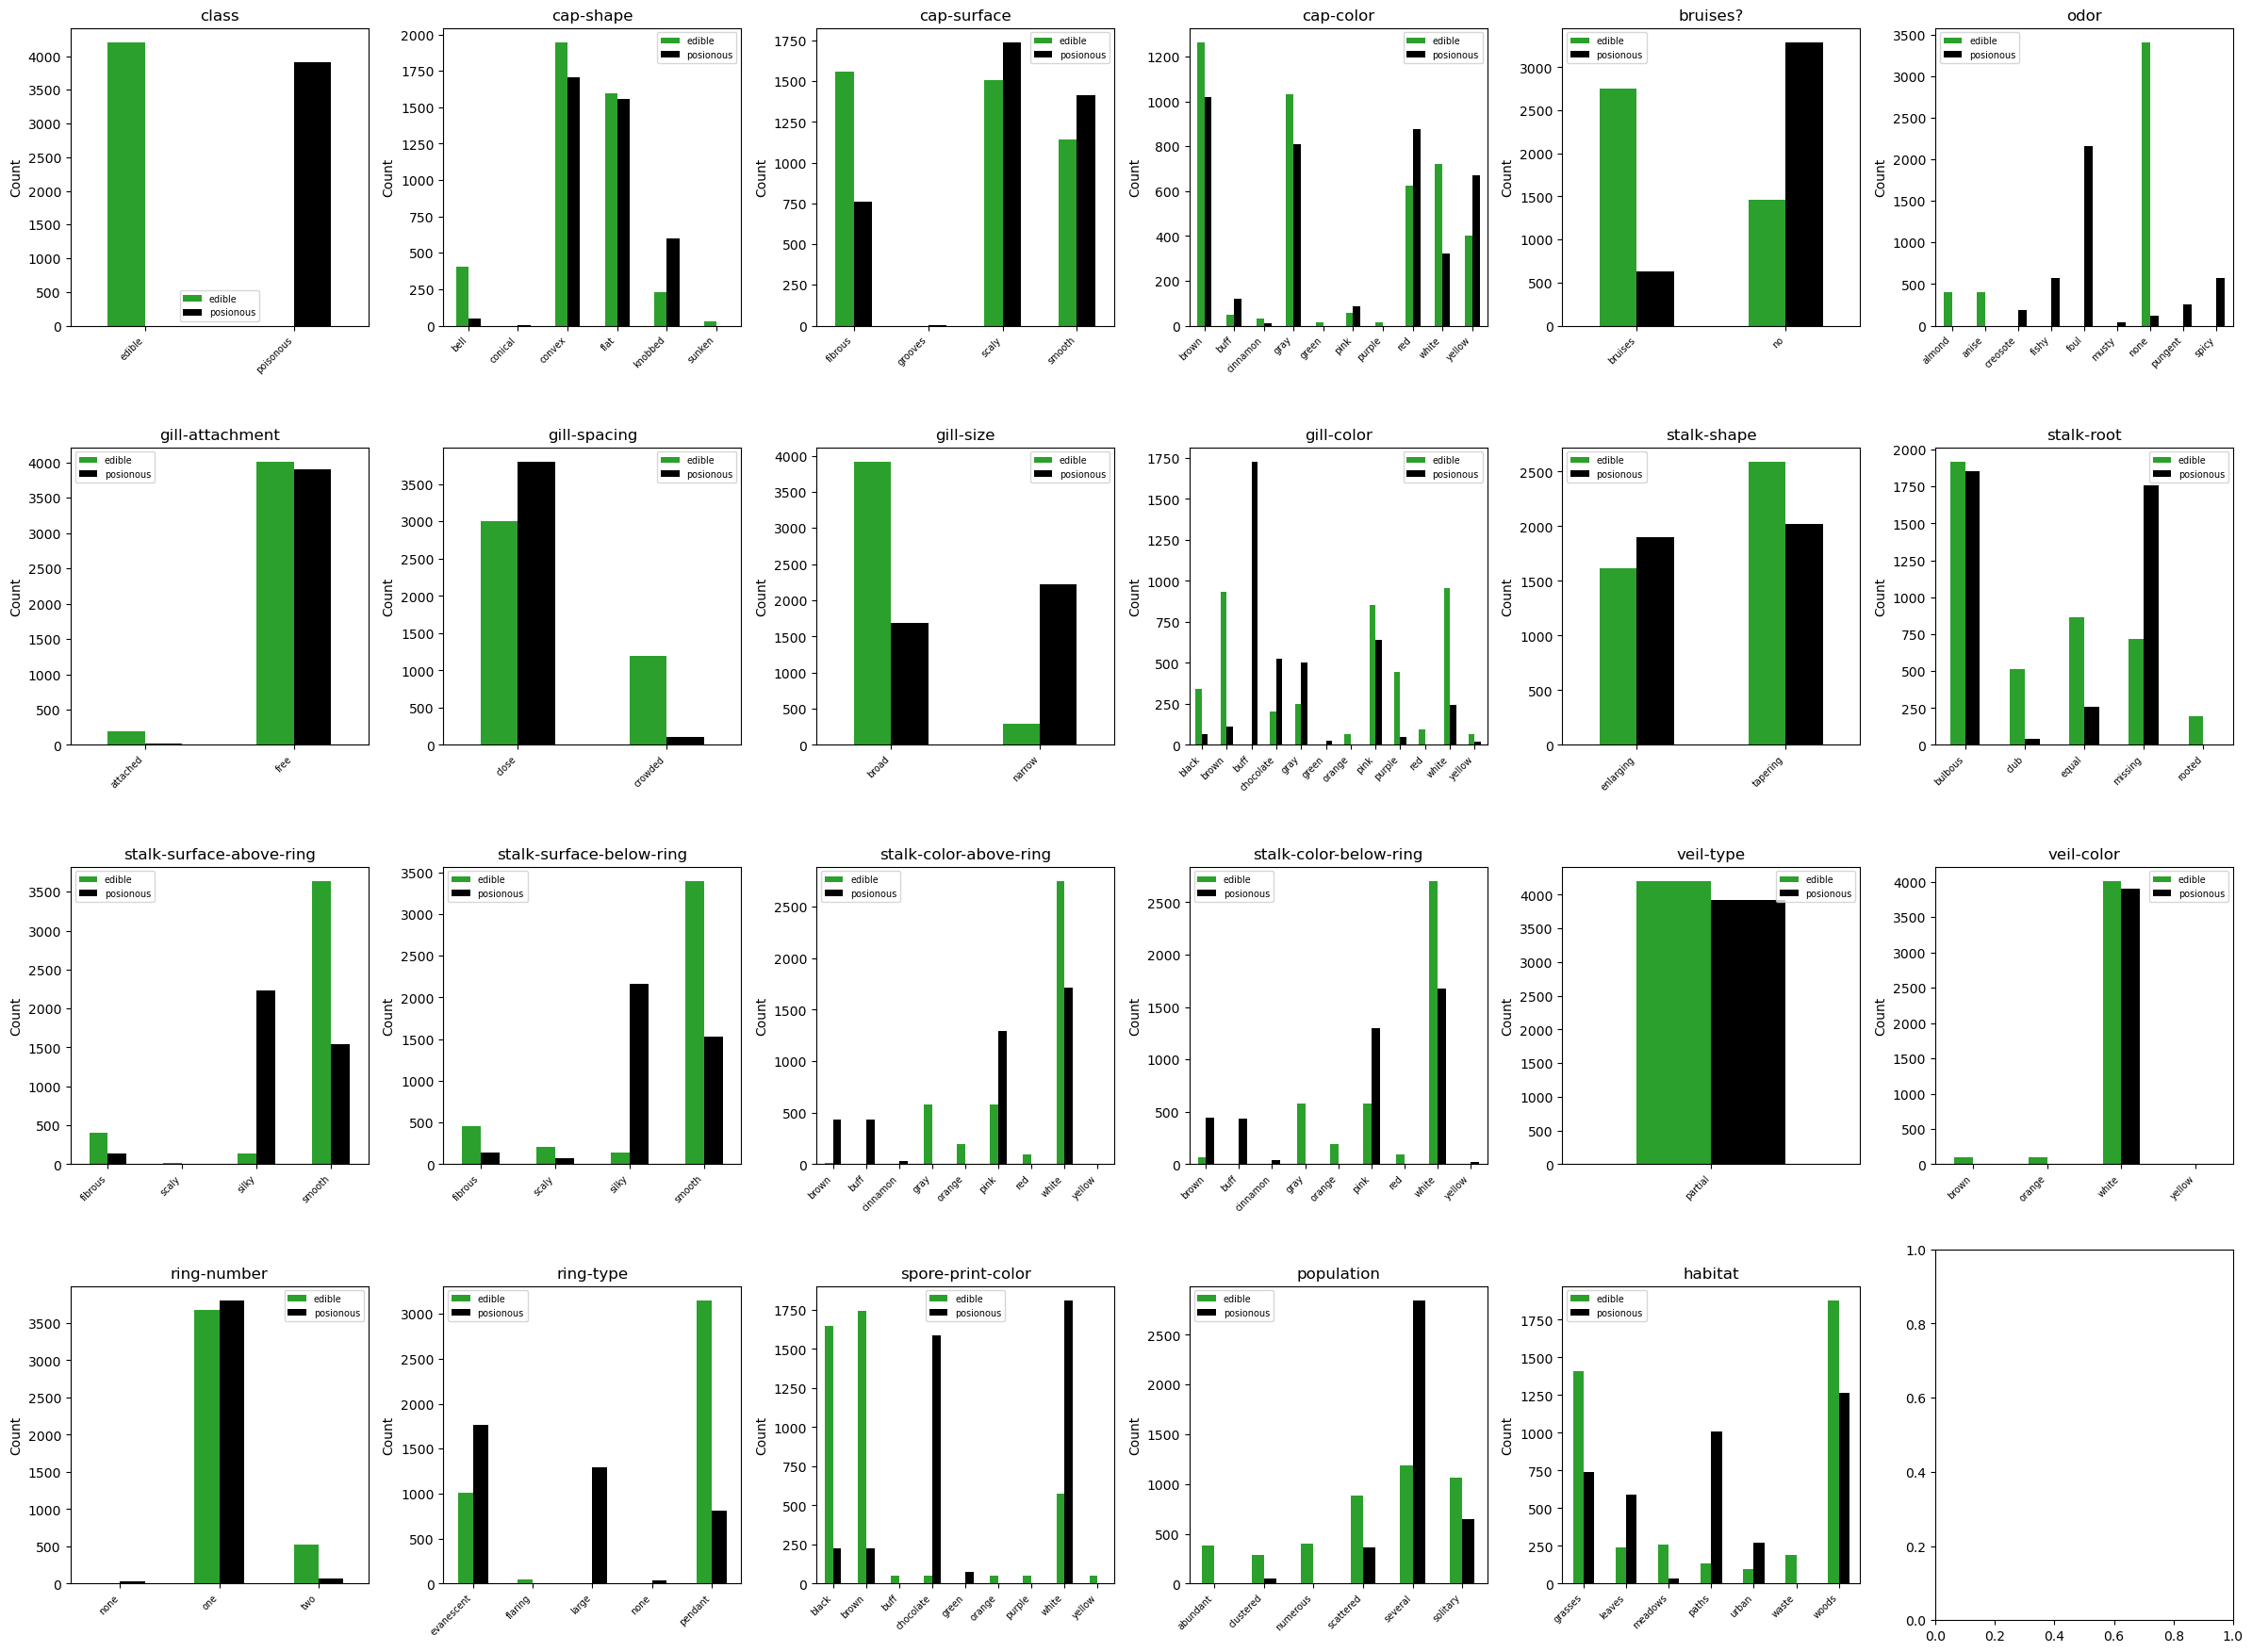

In [12]:
fig, ax = plt.subplots(4,6,figsize=(24,18))

for i, feature in enumerate(mushrooms):
    axis = fig.axes[i]
    pd.crosstab(mushrooms[feature].replace(attribute_mappings[feature]),mushrooms['class']).plot.bar(color=['C2','k'],ax=axis).set_title(feature)
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right',fontsize=7)
    axis.set_ylabel('Count'); axis.set_xlabel(None)
    axis.legend(["edible", "posionous"],fontsize=7);
    
    set_aspect(axis,False,False)

save_fig("attribute_histogram_plots")

Some observations:
- quite a few tail-heavy distributions
- stalk-root category seems to have quite a few missing values labelled '?' (this is confirmed by the data description file agaricus-lepiota.names). We will have to deal with this in the data cleaning section
- odor and spore-print-color seem at first glance to be most indicative of whether a mushroom is poisonous or edible
- only one veil type - not informative so we will drop it from the dataset

In [13]:
mushrooms.drop('veil-type',axis=1,inplace=True)

## Creating a Test Set

Because odor seems to be such an important attribute to predict median housing prices, I would like to ensure that the test set is representative of various categories of odors in the whole dataset. Therefore I will use stratified sampling based on the odor category to get my test set.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(mushrooms, mushrooms['odor']):
    strat_train_set = mushrooms.loc[train_index]
    strat_test_set = mushrooms.loc[test_index]

In [16]:
strat_test_set['odor'].value_counts() / len(strat_test_set)

n    0.434462
f    0.265846
y    0.070769
s    0.070769
a    0.049231
l    0.049231
p    0.031385
c    0.024000
m    0.004308
Name: odor, dtype: float64

In [17]:
mushrooms['odor'].value_counts() / len(mushrooms)

n    0.434269
f    0.265879
y    0.070901
s    0.070901
a    0.049237
l    0.049237
p    0.031512
c    0.023634
m    0.004431
Name: odor, dtype: float64

# Visualizing the Data to Gain Insights

In [18]:
mushrooms = strat_train_set.copy()

I will calculate the uncertainty coefficient, to gain a measure of how the different features relate to one another. This coefficient will provide a value between 0 and 1. Here 0 means that feature b gives no information about feature a, and 1 means that it gives full information.

In [40]:
from collections import Counter

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * np.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

# Reference: https://github.com/shakedzy

In [73]:
us = np.zeros(len(mushrooms.columns))
fs = []
for i, feature in enumerate(mushrooms):
    u = theil_u(mushrooms['class'].tolist(),mushrooms[feature].tolist())
    us[i] = u
    fs.append(feature)

idx = np.argsort(us)[::-1]
for i in range(len(fs)):
    print(fs[idx[i]].ljust(23),'\t', us[idx][i])

class                   	 1.0
odor                    	 0.9039718555982565
spore-print-color       	 0.48414382780541243
gill-color              	 0.41544517654094704
ring-type               	 0.3117056620868067
stalk-surface-above-ring 	 0.2790924781959538
stalk-surface-below-ring 	 0.2683564324463174
stalk-color-above-ring  	 0.24823359270330556
stalk-color-below-ring  	 0.2390756901015747
gill-size               	 0.23176273372670506
population              	 0.20295679188734303
bruises?                	 0.18774491602722024
habitat                 	 0.1574853330252007
stalk-root              	 0.13671571858208972
gill-spacing            	 0.10168051637338403
cap-shape               	 0.047976640656567184
ring-number             	 0.03844999000494731
cap-color               	 0.03659058558570336
cap-surface             	 0.02948369048798835
veil-color              	 0.02403560021952614
gill-attachment         	 0.01524824659221133
stalk-shape             	 0.007029585830425097


Seems like my preliminary assesment was correct and the odor is the most important feature for determining whether a mushroom is edible or not. Perhaps somewhat surprisingly, cap color and surface seem to have very little role in determining the edibility of a mushroom.

Just out of curiosity, I want to look at the uncertainty coefficients for all of the data

In [99]:
udf = pd.DataFrame(index=mushrooms.columns,columns=mushrooms.columns)

for idx in mushrooms.columns:
    for feature in mushrooms.columns:
        u = theil_u(mushrooms[idx].tolist(),mushrooms[feature].tolist())
        udf.at[idx, feature] = u

In [109]:
udf.apply(pd.to_numeric).style.background_gradient(cmap='Reds')

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.047977,0.029484,0.036591,0.187745,0.903972,0.015248,0.101681,0.231763,0.415445,0.007030,0.136716,0.279092,0.268356,0.248234,0.239076,0.024036,0.038450,0.311706,0.484144,0.202957,0.157485
cap-shape,0.029043,1.000000,0.029553,0.068646,0.033541,0.114170,0.007300,0.003177,0.053330,0.116627,0.050123,0.181042,0.019133,0.020260,0.057500,0.055530,0.009532,0.024868,0.085037,0.137987,0.110191,0.104819
cap-surface,0.018706,0.030974,1.000000,0.072005,0.007821,0.104464,0.021128,0.068636,0.037808,0.122178,0.002742,0.159846,0.038184,0.048343,0.111123,0.116096,0.026576,0.009068,0.089722,0.082174,0.124185,0.104309
cap-color,0.014558,0.045116,0.045153,1.000000,0.016488,0.226494,0.017019,0.048220,0.069977,0.219629,0.121603,0.187178,0.063988,0.087645,0.157193,0.158598,0.018967,0.032206,0.170367,0.192349,0.138027,0.187113
bruises?,0.191450,0.056501,0.012570,0.042261,1.000000,0.406251,0.020613,0.079356,0.110163,0.384436,0.006194,0.275426,0.320781,0.312148,0.226950,0.237494,0.019982,0.005547,0.513594,0.295504,0.081365,0.252607
odor,0.389383,0.081240,0.070924,0.245223,0.171605,1.000000,0.014872,0.073653,0.199772,0.373083,0.128054,0.361759,0.183562,0.217298,0.220711,0.215805,0.013109,0.058937,0.323181,0.411627,0.199092,0.215625
gill-attachment,0.088824,0.070243,0.193986,0.249186,0.117754,0.201119,1.000000,0.038398,0.080459,0.660984,0.183689,0.228606,0.054130,0.097411,0.974545,0.974545,0.887114,0.048387,0.177001,0.668967,0.310228,0.439014
gill-spacing,0.159227,0.008220,0.169408,0.189795,0.121863,0.267760,0.010322,1.000000,0.015284,0.151734,0.008946,0.297469,0.160178,0.154212,0.246581,0.219368,0.013954,0.048073,0.120080,0.136559,0.461031,0.328713
gill-size,0.259813,0.098762,0.066804,0.197175,0.121106,0.519911,0.015484,0.010941,1.000000,0.552438,0.038464,0.334685,0.030823,0.023986,0.155616,0.136080,0.016360,0.049817,0.286783,0.369439,0.255135,0.225343
gill-color,0.136984,0.063526,0.063497,0.182023,0.124306,0.285587,0.037414,0.031949,0.162488,1.000000,0.119406,0.270060,0.105856,0.123095,0.163798,0.163925,0.038281,0.054614,0.254605,0.313080,0.169214,0.213491


Looks like in addition to odor, spore-print-color and ring-type are generally useful features to look at